In [2]:
from __future__ import print_function, division

import torch
import torchvision
from torchvision import transforms, datasets, models
import matplotlib.pyplot as plt
import time
import os
import copy
import numpy as np
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn as nn

plt.ion()

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = 'hymenoptera_data'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print(class_names)
print(dataset_sizes)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

['ants', 'bees']
{'train': 244, 'val': 153}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


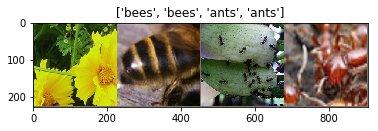

In [4]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
# print(next(iter(dataloaders['train'])))

inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


In [30]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-'*10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
#                 print(labels)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    y_preds = model(inputs)
#                     print(y_preds)
                    _, preds = torch.max(y_preds, 1)
                    loss = criterion(y_preds, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model
                

In [31]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [32]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


In [34]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=50)

Epoch 0/49
----------
train Loss: 0.3461 Acc: 0.8689
val Loss: 0.2618 Acc: 0.9150

Epoch 1/49
----------
train Loss: 0.2315 Acc: 0.8975
val Loss: 0.2471 Acc: 0.9281

Epoch 2/49
----------
train Loss: 0.2704 Acc: 0.8770
val Loss: 0.2508 Acc: 0.9281

Epoch 3/49
----------
train Loss: 0.2959 Acc: 0.8852
val Loss: 0.2405 Acc: 0.9346

Epoch 4/49
----------
train Loss: 0.3170 Acc: 0.8852
val Loss: 0.2422 Acc: 0.9346

Epoch 5/49
----------
train Loss: 0.3540 Acc: 0.8525
val Loss: 0.2487 Acc: 0.9412

Epoch 6/49
----------
train Loss: 0.1848 Acc: 0.9262
val Loss: 0.2570 Acc: 0.9281

Epoch 7/49
----------
train Loss: 0.4036 Acc: 0.8320
val Loss: 0.2457 Acc: 0.9281

Epoch 8/49
----------
train Loss: 0.3011 Acc: 0.8770
val Loss: 0.2582 Acc: 0.9150

Epoch 9/49
----------
train Loss: 0.3221 Acc: 0.8566
val Loss: 0.2361 Acc: 0.9281

Epoch 10/49
----------
train Loss: 0.3542 Acc: 0.8648
val Loss: 0.2457 Acc: 0.9346

Epoch 11/49
----------
train Loss: 0.2287 Acc: 0.9180
val Loss: 0.2490 Acc: 0.9346

Ep

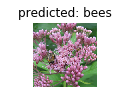

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


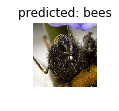

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


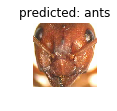

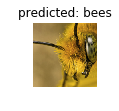

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


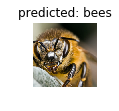

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


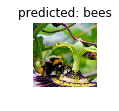

In [39]:
visualize_model(model_ft)